In [1]:
#Esto es solamente para que Jupyter pueda encontrar las librerías necesarias
import sys
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\python37.zip')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\DLLs')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\lib')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32')
sys.path.append('C:\\Users\\Test\\AppData\\Local\\Programs\\Python\\Python37-32\\lib\\site-packages')

In [2]:
from scipy import random
from statistics import mean
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt
import itertools
import emcee
import pandas as pd
import constants
import distance

In [29]:
def muT(data, values):
    zcmb = np.array([dot[1] for dot in data])
    if values[3] < 0: values[3] = 0
    pointer = {"omega_M_0":values[3], "omega_lambda_0":1-values[3], "omega_k_0":0.0, "h":0.7}
    return 5 * np.log10(distance.luminosity_distance(zcmb, **pointer) * 1e6 / 10)

def novaModel(value, dat):
    return value[4] - (dat[2] - dat[0]*value[6] + dat[1]*value[8])

def novaLikelihood(theta, data, theory, sigmaT):
    totalSum = 0
    theory = muT(data, theta)
    for i in range (len(data)): totalSum += (theory[i] - novaModel(data[i], theta))**2 / sigmaT[i]**2
    return -0.5 * totalSum


def novaPrior(theta):
    inf = [-3, 0, -22, 0]
    sup = [3, 6, -16, 1]
    p = np.zeros(4)
    
    for i in range(4):
        if inf[i]< theta[i] <sup[i]: p[i] = -1*np.log(sup[i]-inf[i])
        else: p[i] = 0
    
    return sum(p)

def novaProb(theta, data, theory, sigmaT):
    return novaPrior(theta) + novaLikelihood(theta, data, theory, sigmaT)

In [3]:
dataFrame = pd.read_csv("SNData/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb")
data = np.array(pd.read_csv("SNData/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb"))
dataFrame

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
648,sn1999ac,0.010060,0.009500,0,14.148421,0.174566,0.202688,0.068440,0.048593,0.025981,...,0.128500,51250.610935,0.078970,0.000244,0.000652,-0.000154,3,241.812542,7.972333,-0.008427
691,sn2004s,0.010291,0.009370,0,14.157498,0.173593,-0.117402,0.082511,0.022258,0.024846,...,0.280891,53040.308109,0.290845,-0.000483,0.000665,-0.000348,3,101.431250,-31.231250,-0.008430
641,sn1997do,0.010550,0.010120,0,14.449314,0.173090,0.791332,0.187870,0.118415,0.030547,...,0.280891,50766.597803,0.115604,0.003521,0.000989,0.001322,3,111.677083,47.093333,-0.008434
673,sn2002dp,0.010888,0.011638,0,14.557203,0.169021,-0.316464,0.184325,0.054095,0.023005,...,0.363500,52451.216137,0.133147,0.001596,0.000487,0.001020,3,352.125430,22.427240,-0.008440
713,sn2006bh,0.011184,0.010900,0,14.342973,0.166533,-1.648794,0.032216,-0.083155,0.019407,...,0.352000,53833.523740,0.039787,-0.000039,0.000286,-0.000115,3,340.067078,-66.485085,-0.008446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,06D3en,1.060801,1.060000,0,24.707870,0.132013,-0.952679,0.412773,-0.158207,0.061030,...,0.935000,53881.407872,0.949506,0.010444,-0.003050,0.004456,1,215.305567,52.456079,-0.036389
242,Gabi,1.120850,1.120000,0,25.147113,0.121686,0.620453,0.307485,-0.075491,0.053200,...,0.296000,53488.738514,0.524573,0.004032,0.000388,0.005988,4,189.057630,62.202100,0.000000
243,Lancaster,1.230892,1.230000,0,26.046776,0.128558,-0.077374,0.690464,0.087011,0.048271,...,0.194500,53431.841687,1.597837,0.003542,0.000211,0.008241,4,189.236330,62.214814,0.000000
614,Torngasek,1.265901,1.265000,0,25.735598,0.128614,0.286816,0.559546,0.021062,0.047718,...,0.391000,52693.622067,1.790259,-0.003817,-0.000169,0.003064,4,189.331960,62.310417,0.000000


In [22]:
v0 = np.loadtxt('SNData/jla_v0_covmatrix.dat')
v0 = np.reshape(v0, (740, 740))

v0a = np.loadtxt('SNData/jla_v0a_covmatrix.dat')
v0a = np.reshape(v0a, (740, 740))

v0b = np.loadtxt('SNData/jla_v0b_covmatrix.dat')
v0b = np.reshape(v0b, (740, 740))

va = np.loadtxt('SNData/jla_va_covmatrix.dat')
va = np.reshape(va, (740, 740))

vab = np.loadtxt('SNData/jla_vab_covmatrix.dat')
vab = np.reshape(vab, (740, 740))

vb = np.loadtxt('SNData/jla_vb_covmatrix.dat')
vb = np.reshape(vb, (740, 740))

matrix = v0 + v0a + v0b + va + vab + vb

error = np.array([np.sqrt(matrix[i][i]) for i in range(740)])

In [44]:
#ndim es size
#n_walkers es chainCount
#w_real es valuesT
#des_w es sigmaP
#datos o supernova es data

np.random.seed(200)
NMAX = 10000
size = 4
chainCount = 8
valuesT = [0.14, 3.1, -19.05, 0.5]
sigmaP = [0.01, 0.01, 0.01, 0.01]
theory = muT(data, valuesT)
sigmaT = error

p0 = [[0.16, 3.36, -19.05, 0.29],
      [0.12, 2.48, -19.10, 0.26],
      [0.13, 2.92, -19.22, 0.24], 
      [0.14, 2.52, -19.01, 0.22],
      [0.15, 3.01, -19.15, 0.23],
      [0.11, 3.15, -18.96, 0.27],
      [0.18, 2.73, -19.34, 0.21],
      [0.17, 3.50, -19.55, 0.25]]

In [45]:
fit = emcee.EnsembleSampler(chainCount, size, novaProb, args = [data, theory, sigmaT])

In [46]:
fit.run_mcmc(p0, NMAX, progress = True, store = True)

100%|████████████████████████████████████| 10000/10000 [51:46<00:00,  3.31it/s]


State([[  0.11698315   2.46036974 -19.09603153   0.27916034]
 [  0.12189321   2.44884799 -19.09285412   0.27635469]
 [  0.12449814   2.45706598 -19.09483381   0.28390056]
 [  0.1182261    2.36220594 -19.0988396    0.27754444]
 [  0.12426508   2.41004813 -19.10440655   0.26846774]
 [  0.12361905   2.42567083 -19.09728366   0.27061306]
 [  0.11850688   2.41119821 -19.10208989   0.27081138]
 [  0.11951353   2.41044395 -19.09472862   0.28440028]], log_prob=[-1748.01316399 -1747.9404987  -1748.37179766 -1748.80816982
 -1747.99818336 -1747.45883972 -1747.62229045 -1746.79731183], blobs=None, random_state=('MT19937', array([ 387663297, 2248143987,  935432196, 3254467910,  522065132,
       2179907622,  863660392, 1242500831,  179286026, 4237004038,
       2826305001, 2550245204, 4131554477,  550176315, 2725921494,
       2153201254, 3504408601,  988651580, 2248523916,  348442023,
       4196015238, 1860877729, 1455367326, 2054210183,  499126654,
       1500055039, 3128189604, 1498870096,  940

In [78]:
fitArray = fit.get_chain()
fitArray

array([[[  0.15443918,   3.13952014, -19.06129188,   0.26586765],
        [  0.12      ,   2.48      , -19.1       ,   0.26      ],
        [  0.13327803,   2.8864978 , -19.18955088,   0.23673447],
        ...,
        [  0.11236101,   3.1004187 , -18.96393502,   0.26606498],
        [  0.18      ,   2.73      , -19.34      ,   0.21      ],
        [  0.17      ,   3.5       , -19.55      ,   0.25      ]],

       [[  0.15443918,   3.13952014, -19.06129188,   0.26586765],
        [  0.12      ,   2.48      , -19.1       ,   0.26      ],
        [  0.12711384,   2.9495397 , -19.12306251,   0.24537809],
        ...,
        [  0.11236101,   3.1004187 , -18.96393502,   0.26606498],
        [  0.17456078,   2.74821897, -19.32248519,   0.21311234],
        [  0.17      ,   3.5       , -19.55      ,   0.25      ]],

       [[  0.15443918,   3.13952014, -19.06129188,   0.26586765],
        [  0.12      ,   2.48      , -19.1       ,   0.26      ],
        [  0.12764591,   2.93180407, -19.11839

In [65]:
chains = []
for i in range(chainCount): chains.append([])

for chain in fitArray:
    for i in range(chainCount):
        chains[i].append(chain[i])

In [123]:
chainList, adotsList, bdotsList, mdotsList, odotsList, fullDataSet = [], [], [], [], [], []
for i in range(chainCount): chainList.append([])
        
for chain in fitArray:
    for i in range(len(chain)):
        chainList[i].append(chain[i])

for chain in chainList:
    
    adots, bdots, mdots, odots = [], [], [], []
    
    for array in chain:
        adots.append(array[0])
        bdots.append(array[1])
        mdots.append(array[2])
        odots.append(array[3])
    
    fullDataSet.append(chain[5000:])
    adotsList.append(adots)
    bdotsList.append(bdots)
    mdotsList.append(mdots)
    odotsList.append(odots)

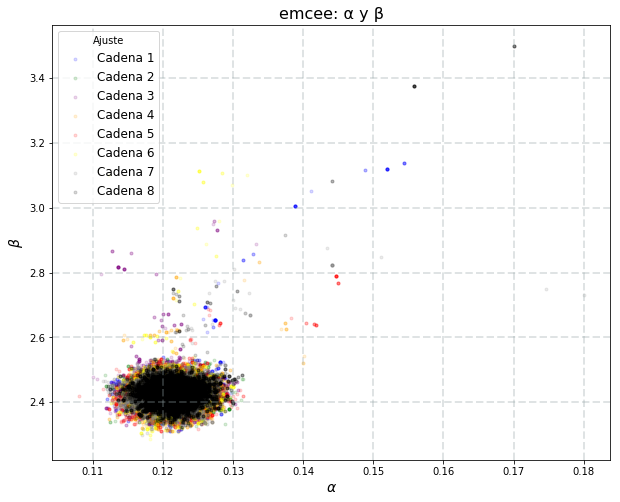

In [119]:
colors = ['blue', 'green', 'purple', 'orange', 'red', 'yellow', 'gray', 'black']
fig, ax0 = plt.subplots(figsize=(10, 8))

for i in range(len(chainList)):
    plt.scatter(adotsList[i], bdotsList[i], color = colors[i], alpha = 0.15, marker = '.',  label = 'Cadena ' + str(i + 1))
    
plt.xlabel('$α$', fontsize = 14)
plt.ylabel('$β$', fontsize = 14)
plt.title('emcee: α y β', fontsize = 16)
plt.legend(title = 'Ajuste', loc = 'upper left', fontsize = 12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.3)

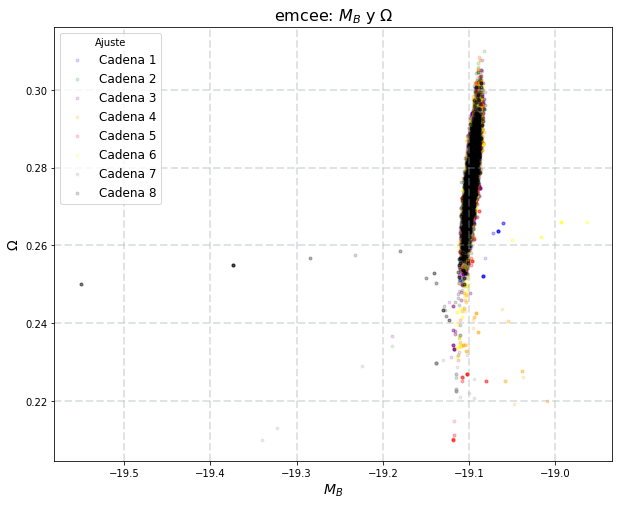

In [130]:
fig, ax0 = plt.subplots(figsize=(10, 8))

for i in range(len(chainList)):
    plt.scatter(mdotsList[i], odotsList[i], color = colors[i], alpha = 0.15, marker = '.',  label = 'Cadena ' + str(i + 1))
    
plt.xlabel('$M_{B}$', fontsize = 14)
plt.ylabel('$\Omega$', fontsize = 14)
plt.title('emcee: $M_{B}$ y $\Omega$', fontsize = 16)
plt.legend(title = 'Ajuste', loc = 'upper left', fontsize = 12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.3)

In [127]:
fullDataSet = list(itertools.chain.from_iterable(fullDataSet))

Removed no burn in


C:\Users\Test\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Test\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Test\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

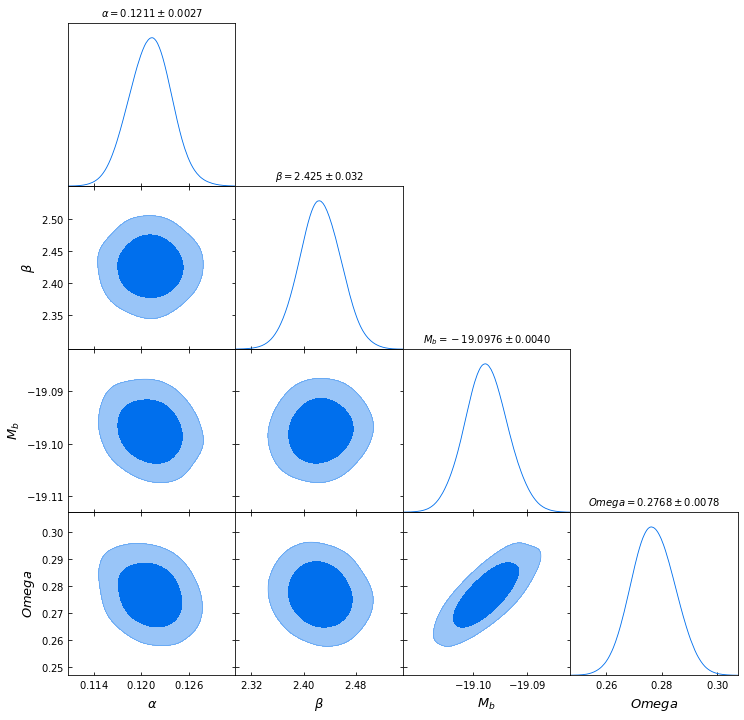

In [129]:
trPlot = plots.get_subplot_plotter(subplot_size=3)
samples = MCSamples(samples = np.array(fullDataSet), labels = ['α', 'β', 'M_b', 'Omega'], names = ['α', 'β', 'M_b', 'Omega'])
trPlot.triangle_plot(samples, filled=True, title_limit=1)

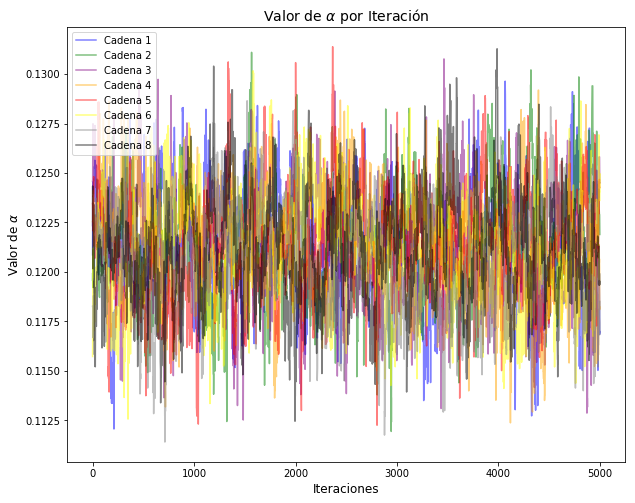

In [141]:
iterations = list(range(5000))

fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $α$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $α$ por Iteración', fontsize = 14)

for i in range(chainCount):
    plt.plot(iterations, adotsList[i][5000:], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

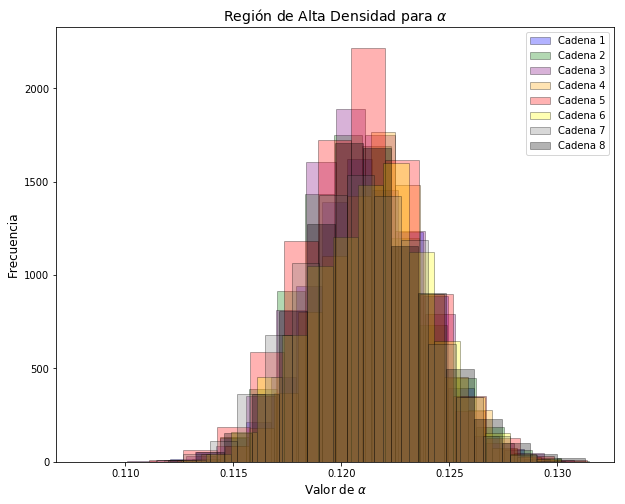

In [147]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.xlabel('Valor de $α$', fontsize = 12)
plt.ylabel('Frecuencia', fontsize = 12)
plt.title('Región de Alta Densidad para $α$', fontsize = 14)

for i in range(chainCount):
    plt.hist(adotsList[i][1000:], color = colors[i], bins = 15, alpha = 0.3, align = 'mid', label = 'Cadena ' + str(i + 1), ec = 'black')

plt.legend()
plt.show()

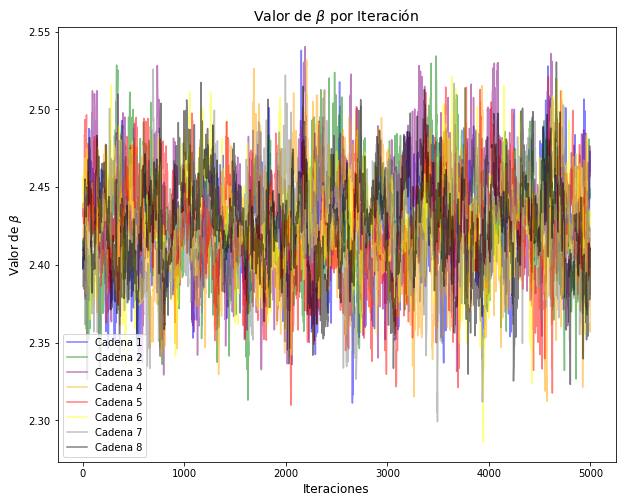

In [142]:
iterations = list(range(5000))

fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $β$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $β$ por Iteración', fontsize = 14)

for i in range(chainCount):
    plt.plot(iterations, bdotsList[i][5000:], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

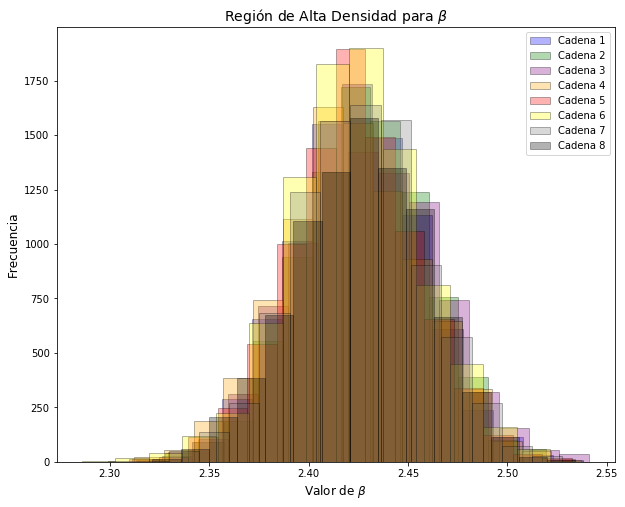

In [148]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.xlabel('Valor de $β$', fontsize = 12)
plt.ylabel('Frecuencia', fontsize = 12)
plt.title('Región de Alta Densidad para $β$', fontsize = 14)

for i in range(chainCount):
    plt.hist(bdotsList[i][1000:], color = colors[i], bins = 15, alpha = 0.3, align = 'mid', label = 'Cadena ' + str(i + 1), ec = 'black')

plt.legend()
plt.show()

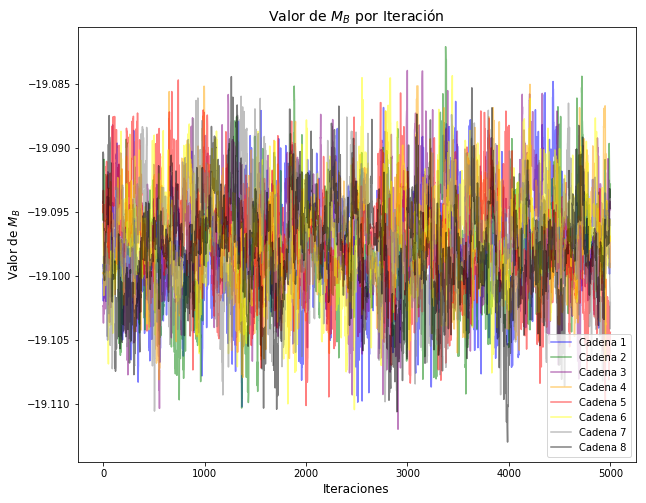

In [143]:
iterations = list(range(5000))

fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $M_{B}$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $M_{B}$ por Iteración', fontsize = 14)

for i in range(chainCount):
    plt.plot(iterations, mdotsList[i][5000:], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

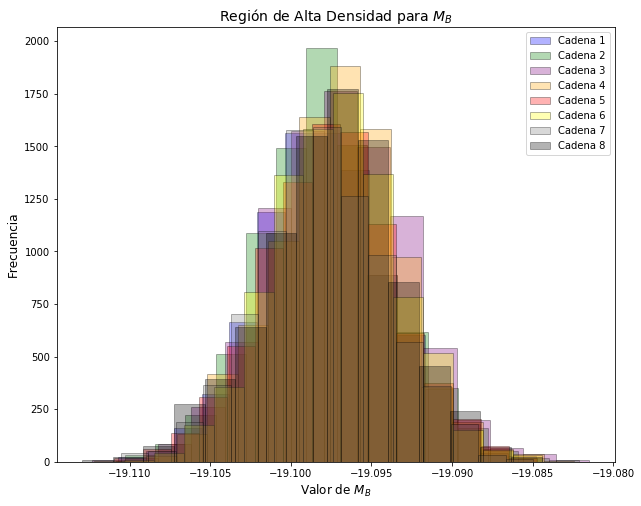

In [151]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.xlabel('Valor de $M_{B}$', fontsize = 12)
plt.ylabel('Frecuencia', fontsize = 12)
plt.title('Región de Alta Densidad para $M_{B}$', fontsize = 14)

for i in range(chainCount):
    plt.hist(mdotsList[i][1000:], color = colors[i], bins = 15, alpha = 0.3, align = 'mid', label = 'Cadena ' + str(i + 1), ec = 'black')

plt.legend()
plt.show()

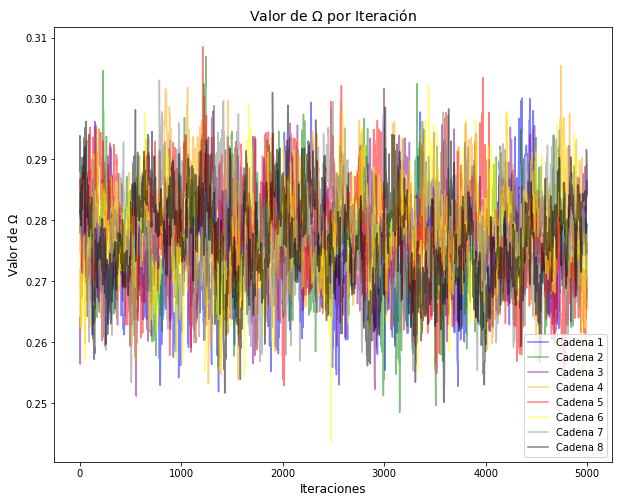

In [144]:
iterations = list(range(5000))

fig, ax0 = plt.subplots(figsize=(10, 8))

plt.ylabel('Valor de $\Omega$', fontsize = 12)
plt.xlabel('Iteraciones', fontsize = 12)
plt.title('Valor de $\Omega$ por Iteración', fontsize = 14)

for i in range(chainCount):
    plt.plot(iterations, odotsList[i][5000:], color = colors[i], alpha = 0.5, label = 'Cadena ' + str(i + 1))

plt.legend()
plt.show()

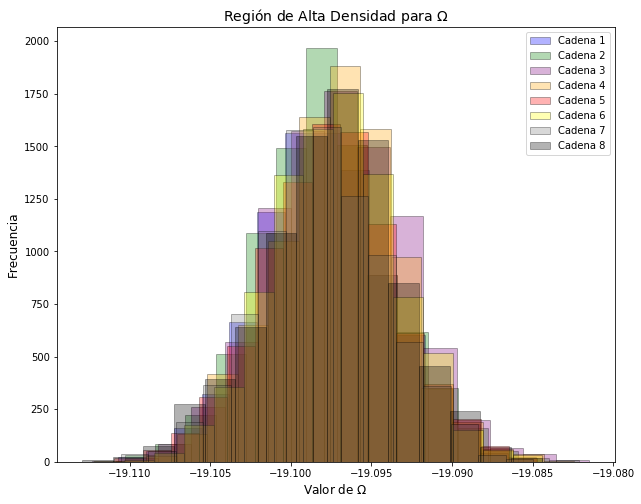

In [152]:
fig, ax0 = plt.subplots(figsize=(10, 8))

plt.xlabel('Valor de $\Omega$', fontsize = 12)
plt.ylabel('Frecuencia', fontsize = 12)
plt.title('Región de Alta Densidad para $\Omega$', fontsize = 14)

for i in range(chainCount):
    plt.hist(mdotsList[i][1000:], color = colors[i], bins = 15, alpha = 0.3, align = 'mid', label = 'Cadena ' + str(i + 1), ec = 'black')

plt.legend()
plt.show()